In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set directory to location of OULAD dataset in google drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [4]:
ls

anonymisedOUDataSet/       learning_behaviour_npv.pdf
Deadline/                  pass_fail_rate_modules.pdf
demographic_f1.pdf         performance_f1.pdf
demographic_npv.pdf        performance_npv.pdf
learning_behaviour_f1.pdf  StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [5]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# All Modules

## Setup

### Load dataset and remove column features that are not used in module

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
module_titles = ["Module FFF", "Module EEE", "Module BBB"]
classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

df_FFF = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_FFF_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # fail course = 0 | pass course = 1
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df_FFF[i] = temp


df_EEE = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_EEE_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # fail course = 0 | pass course = 1
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df_EEE[i] = temp

df_BBB = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_BBB_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # fail course = 0 | pass course = 1
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df_BBB[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Helper functions

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [8]:
def plot_confusion_matrix(result):
  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [9]:
def plot_days_compare(deadline_list,result,labels,title,modules,pdf_filename):

  fig, axs = plt.subplots(1, 3,figsize=(15, 5))
  fig.suptitle(title, y=1.07)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2)
  for index, ax_i in enumerate(axs):
    for i in range(len(result[index])):

      plt_days = sns.lineplot(x=deadline_list,y=np.array(result[index][i], dtype=object)[:,1],marker="o", label=labels[i], ax=ax_i, legend=False)


      plt_days.set_title(modules[index])
      plt_days.set_ylabel("F1 Score")
  fig.text(0.5,-0.04, 'Number of days through module', ha='center', fontsize=13)

  fig.legend(axs, labels = labels, bbox_to_anchor=(1.01,0.58), loc="center left")
  plt.savefig(pdf_filename, bbox_inches="tight")

In [10]:
def plot_days_compare_npv(deadline_list,result,labels,title,modules,pdf_filename):

  fig, axs = plt.subplots(1, 3,figsize=(15, 5))
  fig.suptitle(title, y=1.07)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2)
  for index, ax_i in enumerate(axs):
    for i in range(len(result[index])):

      npv = []

      for j in np.array(result[index][i], dtype=object)[:,4]:
        tn, fp, fn, tp = j.ravel()

        # Prevent zero division error
        if fn == 0:
          npv.append(0)
        else:
          npv.append(tn/(tn+fn))

      plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i], ax=ax_i, legend=False)


      plt_days.set_title(modules[index])
      plt_days.set_ylabel("Negative Predictive Value")
  fig.text(0.5,-0.04, 'Number of days through module', ha='center', fontsize=13)

  fig.legend(axs, labels = labels, bbox_to_anchor=(1.01,0.58), loc="center left")
  plt.savefig(pdf_filename, bbox_inches="tight")

In [11]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [12]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [13]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [14]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [15]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [16]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [17]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [19]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Make predictions

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [21]:
demographic_df_FFF = {}
for i in df_FFF.keys():
  demographic_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['demographic'], include_final_result=True)

demographic_df_EEE = {}
for i in df_EEE.keys():
  demographic_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['demographic'], include_final_result=True)

demographic_df_BBB = {}
for i in df_BBB.keys():
  demographic_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['demographic'], include_final_result=True)

###### Encode data

In [22]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(demographic_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(demographic_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(demographic_df_BBB, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(

###### Feature selection

In [23]:
for i in df_FFF.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train_FFF[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_FFF[i], Y_train_FFF[i]))
  
  X_test_FFF[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_FFF[i]))


for i in df_EEE.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train_EEE[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_EEE[i], Y_train_EEE[i]))
  
  X_test_EEE[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_EEE[i]))


for i in df_BBB.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train_BBB[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_BBB[i], Y_train_BBB[i]))
  
  X_test_BBB[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_BBB[i]))

##### DummyClassifier

In [24]:
from sklearn.dummy import DummyClassifier

def demographic_du(df,X_train,Y_train,X_test,Y_test):
  demographic_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return demographic_results_du

In [25]:
demographic_results_du_FFF = demographic_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_du_EEE = demographic_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_du_BBB = demographic_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.485
Best parameters set:
Accuracy: 0.5060698027314112, F1 Score: 0.6052152819890844, Precision: 0.7595129375951294, Recall: 0.5030241935483871


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [26]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

def demographic_nb(df,X_train,Y_train,X_test,Y_test):
  demographic_results_nb = []

  pipeline = Pipeline([
      ('clf', BernoulliNB(binarize=None)),
  ])

  params = {
    #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_nb

In [27]:
demographic_results_nb_FFF = demographic_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_nb_EEE = demographic_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_nb_BBB = demographic_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.562
Best parameters set:
Accuracy: 0.7071320182094082, F1 Score: 0.8118908382066277, Precision: 0.7858490566037736, Recall: 0.8397177419354839


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.7150108774474256, F1 Score: 0.8203017832647463, Precision: 0.7847769028871391, Recall: 0.8591954022988506


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.713150289017341, F1 Score: 0.818969448244414, Precision: 0.7822299651567944, Recall: 0.8593301435406698


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.558
Best p

##### LogisticRegression

ovr is used for binary problems

In [28]:
from sklearn.linear_model import LogisticRegression

def demographic_lr(df,X_train,Y_train,X_test,Y_test):
  demographic_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(multi_class='ovr')),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_lr

In [29]:
demographic_results_lr_FFF = demographic_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_lr_EEE = demographic_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_lr_BBB = demographic_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.516
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7503793626707133, F1 Score: 0.8524001794526692, Precision: 0.7679870654810024, Recall: 0.9576612903225806


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7469180565627266, F1 Score: 0.8505353319057816, Precision: 0.7691711851278079, Recall: 0.9511494252873564


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.744942196531792, F1 Score: 0.849209739427595, Precision: 0.7669753086419753, Recall: 0.9511961722488

##### WeightedLogisticRegression

In [30]:
def demographic_lrw(df,X_train,Y_train,X_test,Y_test):
  demographic_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_lrw

In [31]:
demographic_results_lrw_FFF = demographic_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_lrw_EEE = demographic_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_lrw_BBB = demographic_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.569
Best parameters set:
Accuracy: 0.5842185128983308, F1 Score: 0.6857798165137614, Precision: 0.7952127659574468, Recall: 0.6028225806451613


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5808556925308195, F1 Score: 0.67853170189099, Precision: 0.8090185676392573, Recall: 0.5842911877394636


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5802023121387283, F1 Score: 0.677759290072102, Precision: 0.8060686015831134, Recall: 0.584688995215311


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.566
Best par

##### RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier

def demographic_rf(df,X_train,Y_train,X_test,Y_test):

  demographic_results_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_rf.append([acc, f1, prec, recall, conf])
    print("\n")

  return demographic_results_rf

In [33]:
demographic_results_rf_FFF = demographic_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_rf_EEE = demographic_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_rf_BBB = demographic_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.557
Best parameters set:
	clf__n_estimators: 140
Accuracy: 0.6062215477996965, F1 Score: 0.7220139260846277, Precision: 0.7702857142857142, Recall: 0.6794354838709677


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.549
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.5902828136330674, F1 Score: 0.7086126869520373, Precision: 0.7675977653631285, Recall: 0.6580459770114943


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.549
Best parameters set:
	clf__n_estimato

##### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

def demographic_ab(df,X_train,Y_train,X_test,Y_test):
  demographic_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    demographic_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return demographic_results_ab

In [35]:
demographic_results_ab_FFF = demographic_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

demographic_results_ab_EEE = demographic_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

demographic_results_ab_BBB = demographic_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.526
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7382397572078907, F1 Score: 0.841960604672469, Precision: 0.7716204869857263, Recall: 0.9264112903225806


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7469180565627266, F1 Score: 0.8505353319057816, Precision: 0.7691711851278079, Recall: 0.9511494252873564


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.744942196531792, F1 Sco

##### Plot results overview

In [36]:
demographic_classifier_results_FFF = [demographic_results_du_FFF, demographic_results_nb_FFF, demographic_results_lr_FFF, demographic_results_lrw_FFF, demographic_results_rf_FFF, demographic_results_ab_FFF]
demographic_classifier_results_EEE = [demographic_results_du_EEE, demographic_results_nb_EEE, demographic_results_lr_EEE, demographic_results_lrw_EEE, demographic_results_rf_EEE, demographic_results_ab_EEE]
demographic_classifier_results_BBB = [demographic_results_du_BBB, demographic_results_nb_BBB, demographic_results_lr_BBB, demographic_results_lrw_BBB, demographic_results_rf_BBB, demographic_results_ab_BBB]

demographic_classifier_results = [demographic_classifier_results_FFF,demographic_classifier_results_EEE,demographic_classifier_results_BBB]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


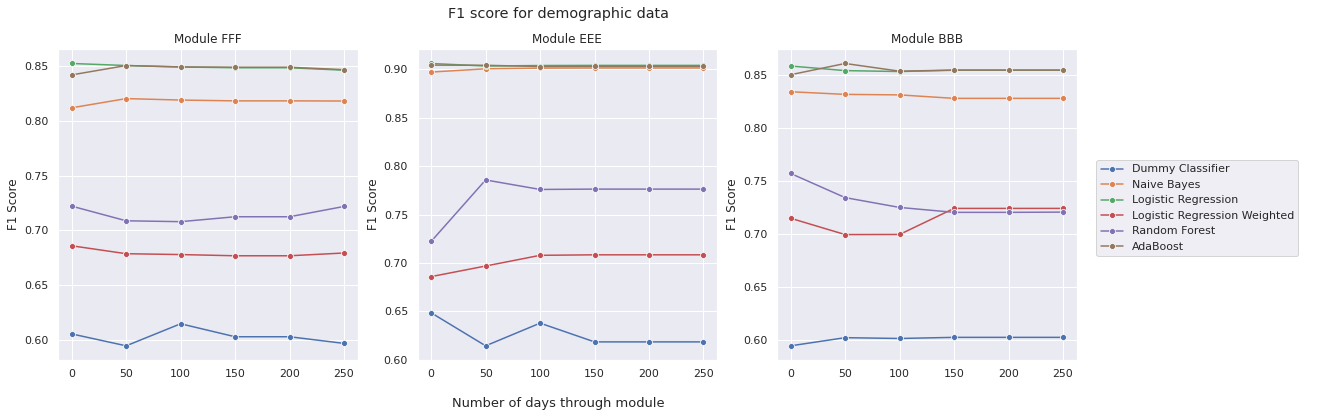

In [37]:
plot_days_compare(deadline_list,demographic_classifier_results,classifier_labels, "F1 score for demographic data", module_titles, "demographic_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


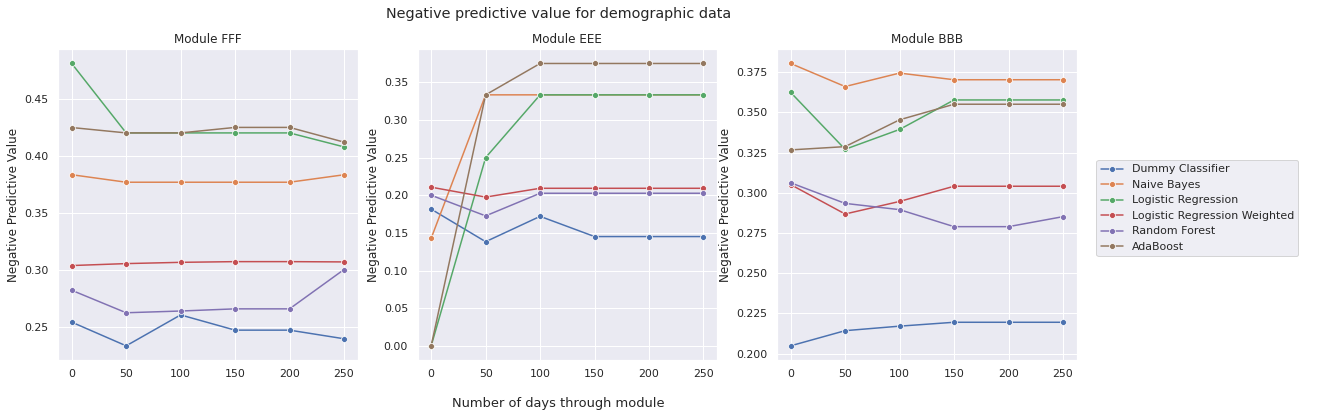

In [38]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,classifier_labels, "Negative predictive value for demographic data", module_titles, "demographic_npv.pdf")

#### Learning behaviour data

##### Prepare data for prediction

In [39]:
learning_behaviour_df_FFF = {}
for i in df_FFF.keys():
  learning_behaviour_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['learning_behaviour'], include_final_result=True)

learning_behaviour_df_EEE = {}
for i in df_EEE.keys():
  learning_behaviour_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['learning_behaviour'], include_final_result=True)

learning_behaviour_df_BBB = {}
for i in df_BBB.keys():
  learning_behaviour_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['learning_behaviour'], include_final_result=True)

###### Encode data

In [40]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(learning_behaviour_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(learning_behaviour_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(learning_behaviour_df_BBB, ["2013J"], "2014J")

Index([], dtype='object') Index(['mean_click', 'forumng', 'subpage', 'oucontent', 'glossary', 'ouwiki',
       'homepage', 'quiz', 'resource', 'url', 'oucollaborate', 'dualpane',
       'page', 'questionnaire'],
      dtype='object')
Index([], dtype='object') Index(['mean_click', 'forumng', 'subpage', 'oucontent', 'glossary', 'ouwiki',
       'homepage', 'quiz', 'resource', 'url', 'oucollaborate', 'dualpane',
       'page', 'questionnaire'],
      dtype='object')
Index([], dtype='object') Index(['mean_click', 'forumng', 'subpage', 'oucontent', 'glossary', 'ouwiki',
       'homepage', 'quiz', 'resource', 'url', 'oucollaborate', 'dualpane',
       'repeatactivity', 'page', 'questionnaire'],
      dtype='object')
Index([], dtype='object') Index(['mean_click', 'page', 'ouwiki', 'homepage', 'resource', 'oucollaborate',
       'repeatactivity', 'questionnaire', 'forumng', 'quiz', 'url', 'subpage',
       'dataplus', 'oucontent', 'glossary', 'folder', 'dualpane'],
      dtype='object')
Index(

###### Feature selection

In [41]:
for i in df_FFF.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train_FFF[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_FFF[i], Y_train_FFF[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train_FFF[i].index)
  
  X_test_FFF[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_FFF[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test_FFF[i].index)

for i in df_EEE.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train_EEE[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_EEE[i], Y_train_EEE[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train_EEE[i].index)
  
  X_test_EEE[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_EEE[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test_EEE[i].index)


for i in df_BBB.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train_BBB[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_BBB[i], Y_train_BBB[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train_BBB[i].index)
  
  X_test_BBB[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_BBB[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test_BBB[i].index)

##### DummyClassifier

In [42]:
def learning_behaviour_du(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return learning_behaviour_results_du

In [43]:
learning_behaviour_results_du_FFF = learning_behaviour_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_du_EEE = learning_behaviour_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_du_BBB = learning_behaviour_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.485
Best parameters set:
Accuracy: 0.5060698027314112, F1 Score: 0.6052152819890844, Precision: 0.7595129375951294, Recall: 0.5030241935483871


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best

##### NaiveBayes

In [44]:
def learning_behaviour_nb(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_nb = []

  pipeline = Pipeline([
      ('clf', ComplementNB()),
  ])

  params = {
    #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return learning_behaviour_results_nb

In [45]:
learning_behaviour_results_nb_FFF = learning_behaviour_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_nb_EEE = learning_behaviour_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_nb_BBB = learning_behaviour_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.503
Best parameters set:
Accuracy: 0.4271623672230653, F1 Score: 0.4509090909090909, Precision: 0.8093994778067886, Recall: 0.3125


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.636
Best parameters set:
Accuracy: 0.5387962291515591, F1 Score: 0.6025, Precision: 0.8669064748201439, Recall: 0.4616858237547893


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.659
Best parameters set:
Accuracy: 0.5267341040462428, F1 Score: 0.5862286797220467, Precision: 0.862453531598513, Recall: 0.44401913875598087


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.664
Best parameters set:
Accurac

##### LogisticRegression

In [46]:
def learning_behaviour_lr(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression()),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return learning_behaviour_results_lr

In [47]:
learning_behaviour_results_lr_FFF = learning_behaviour_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_lr_EEE = learning_behaviour_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_lr_BBB = learning_behaviour_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.414
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7526555386949925, F1 Score: 0.8588744588744589, Precision: 0.7526555386949925, Recall: 1.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.634
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7737490935460478, F1 Score: 0.8575342465753425, Precision: 0.819371727748691, Recall: 0.8994252873563219


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.655
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7644508670520231, F1 Score: 0.8505957836846929, Precision: 0.8161829375549692, Recall: 0.8880382775119617


Day 150
Pe

##### WeightedLogisticRegression

In [48]:
def learning_behaviour_lrw(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(class_weight = 'balanced')),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return learning_behaviour_results_lrw

In [49]:
learning_behaviour_results_lrw_FFF = learning_behaviour_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_lrw_EEE = learning_behaviour_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_lrw_BBB = learning_behaviour_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.589
Best parameters set:
Accuracy: 0.5887708649468892, F1 Score: 0.6687041564792175, Precision: 0.8493788819875776, Recall: 0.5514112903225806


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.667
Best parameters set:
Accuracy: 0.6446700507614214, F1 Score: 0.7295805739514348, Precision: 0.8606770833333334, Recall: 0.6331417624521073


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.677
Best parameters set:
Accuracy: 0.6459537572254336, F1 Score: 0.7268673355629877, Precision: 0.8704939919893191, Recall: 0.6239234449760765


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.693
Best

##### RandomForest

In [50]:
def learning_behaviour_rf(df,X_train,Y_train,X_test,Y_test):

  learning_behaviour_results_rf = []
  learning_behaviour_features_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
    learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])

    print("\n")

  return learning_behaviour_results_rf, learning_behaviour_features_rf

In [51]:
learning_behaviour_results_rf_FFF,learning_behaviour_features_rf_FFF = learning_behaviour_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_rf_EEE,learning_behaviour_features_rf_EEE = learning_behaviour_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_rf_BBB,learning_behaviour_features_rf_BBB = learning_behaviour_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.567
Best parameters set:
	clf__n_estimators: 140
Accuracy: 0.6843702579666161, F1 Score: 0.7950738916256158, Precision: 0.7774566473988439, Recall: 0.813508064516129


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.612
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.719361856417694, F1 Score: 0.8182245185533116, Precision: 0.8027649769585253, Recall: 0.8342911877394636


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.609
Best parameters set:
	clf__n_estimators:

##### AdaBoost

In [52]:
def learning_behaviour_ab(df,X_train,Y_train,X_test,Y_test):
  learning_behaviour_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return learning_behaviour_results_ab

In [53]:
learning_behaviour_results_ab_FFF = learning_behaviour_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

learning_behaviour_results_ab_EEE = learning_behaviour_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

learning_behaviour_results_ab_BBB = learning_behaviour_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.520
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.7207890743550834, F1 Score: 0.8229066410009624, Precision: 0.787292817679558, Recall: 0.8618951612903226


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.655
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7541696881798404, F1 Score: 0.8413664014974264, Precision: 0.8225068618481244, Recall: 0.8611111111111112


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.665
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.7384393063583815, 

##### Plot results overview

In [54]:
learning_behaviour_classifier_results_FFF = [learning_behaviour_results_du_FFF, learning_behaviour_results_nb_FFF, learning_behaviour_results_lr_FFF, learning_behaviour_results_lrw_FFF, learning_behaviour_results_rf_FFF, learning_behaviour_results_ab_FFF]
learning_behaviour_classifier_results_EEE = [learning_behaviour_results_du_EEE, learning_behaviour_results_nb_EEE, learning_behaviour_results_lr_EEE, learning_behaviour_results_lrw_EEE, learning_behaviour_results_rf_EEE, learning_behaviour_results_ab_EEE]
learning_behaviour_classifier_results_BBB = [learning_behaviour_results_du_BBB, learning_behaviour_results_nb_BBB, learning_behaviour_results_lr_BBB, learning_behaviour_results_lrw_BBB, learning_behaviour_results_rf_BBB, learning_behaviour_results_ab_BBB]

learning_behaviour_classifier_results = [learning_behaviour_classifier_results_FFF,learning_behaviour_classifier_results_EEE,learning_behaviour_classifier_results_BBB]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


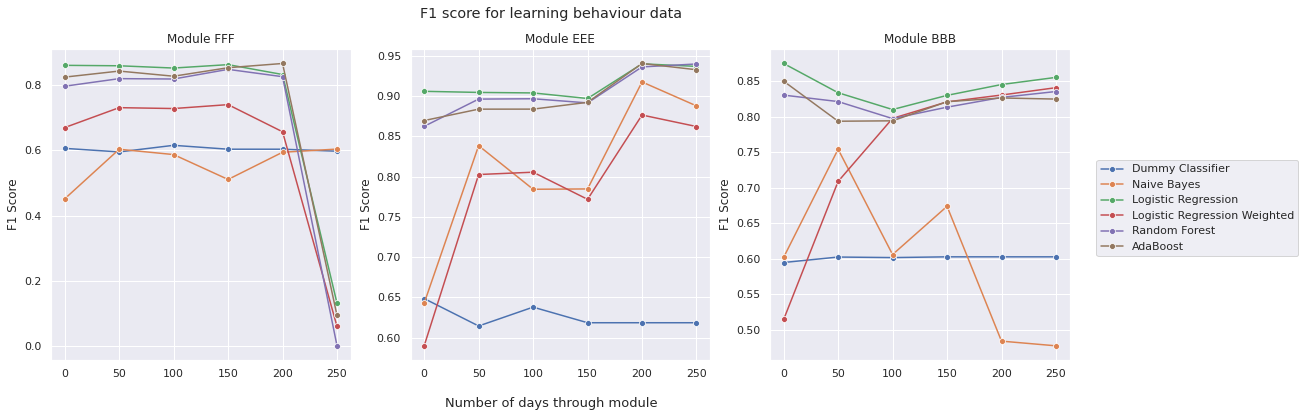

In [55]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,classifier_labels, "F1 score for learning behaviour data", module_titles, "learning_behaviour_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


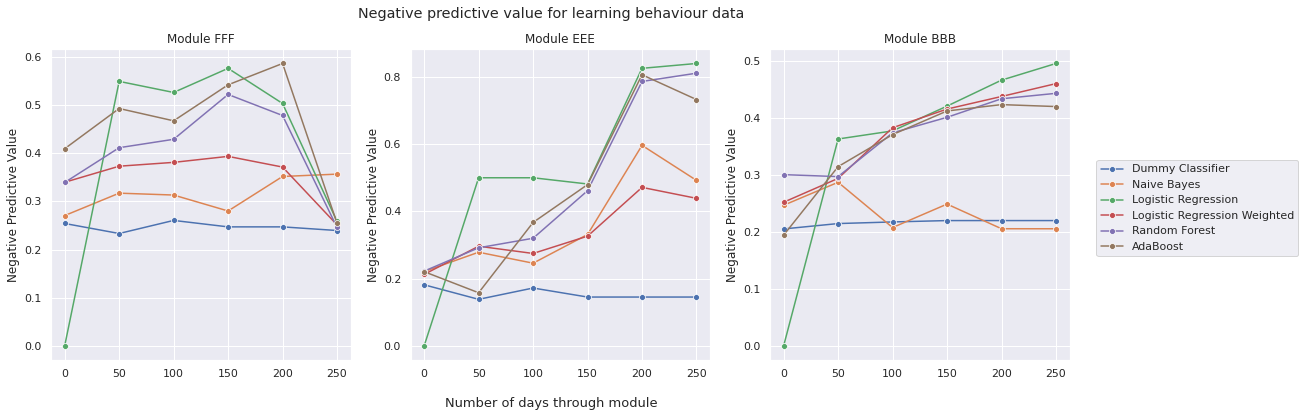

In [56]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,classifier_labels, "Negative predictive value for learning behaviour data", module_titles, "learning_behaviour_npv.pdf")

#### Performance data

##### Prepare data for prediction

In [57]:
performance_df_FFF = {}
for i in df_FFF.keys():
  performance_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['performance'], include_final_result=True)

performance_df_EEE = {}
for i in df_EEE.keys():
  performance_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['performance'], include_final_result=True)

performance_df_BBB = {}
for i in df_BBB.keys():
  performance_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['performance'], include_final_result=True)

In [58]:
performance_df_FFF[50]

,code_presentation,id_student,weighted_score,score,final_result
0,2013B,33915,22.680,90.0,1
1,2013B,35544,21.672,86.0,1
2,2013B,35860,21.168,84.0,1
3,2013B,42668,18.648,74.0,1
4,2013B,43273,20.412,81.0,1
...,...,...,...,...,...
4797,2014J,2681198,8.316,66.0,1
4798,2014J,2682682,12.096,96.0,1
4799,2014J,2683857,9.072,72.0,1
4800,2014J,2693932,11.340,90.0,1


###### Encode data

In [59]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(performance_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(performance_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(performance_df_BBB, ["2013J"], "2014J")

Index([], dtype='object') Index([], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index([], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object')
Index([], dtype='object') Index([], dtype='object')
Index([], dtype='object') Index(['weighted_score', 'score'], dtype='object

##### DummyClassifier

In [60]:
def performance_du(df,X_train,Y_train,X_test,Y_test):
  performance_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return performance_results_du

In [61]:
performance_results_du_FFF = performance_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_du_EEE = performance_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_du_BBB = performance_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5014430014430015, F1 Score: 0.6026451983898793, Precision: 0.7550432276657061, Recall: 0.5014354066985646


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Be

##### NaiveBayes

In [62]:
def performance_nb(df,X_train,Y_train,X_test,Y_test):
  performance_results_nb = []

  pipeline = Pipeline([
      ('clf', ComplementNB()),
  ])

  params = {
    #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return performance_results_nb

In [63]:
performance_results_nb_FFF = performance_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_nb_EEE = performance_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_nb_BBB = performance_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.629
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.805
Best parameters set:
Accuracy: 0.8569364161849711, F1 Score: 0.9129287598944591, Precision: 0.8445890968266884, Recall: 0.9933014354066986


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.843
Best parameters set:
Accuracy: 0.886002886002886, F1 Score: 0.928635953026197, Precision: 0.8793840889649273, Recall: 0.9837320574162679


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.852
Best parameters set:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8946608946608947, F1 Score: 0.9342342342342342, Precision: 0.8825531914893617, Recall: 0.9923444976076555


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.860
Best parameters set:
Accuracy: 0.8889689978370584, F1 Score: 0.9298085688240657, Precision: 0.8885017421602788, Recall: 0.9751434034416826


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.165
Best parameters set:
Accuracy: 0.5159235668789809, F1 Score: 0.6353166986564299, Precision: 0.8422391857506362, Recall: 0.5100154083204931


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.712
Best parameters set:
Accuracy: 0.8542458808618505, F1 Score: 0.9173256649892164, Precision: 0.8633288227334236, Recall: 0.9785276073619632


Day 150
Performing grid se

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.849
Best parameters set:
Accuracy: 0.9079214624238321, F1 Score: 0.943238731218698, Precision: 0.9018355945730248, Recall: 0.9886264216972879




##### LogisticRegression

In [64]:
def performance_lr(df,X_train,Y_train,X_test,Y_test):
  performance_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression()),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return performance_results_lr

In [65]:
performance_results_lr_FFF = performance_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_lr_EEE = performance_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_lr_BBB = performance_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.709
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.853
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8663294797687862, F1 Score: 0.9162516976007243, Precision: 0.8694158075601375, Recall: 0.968421052631579


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.878
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.8845598845598845, F1 Score: 0.9269406392694063, Precision: 0.8864628820960698, Recall: 0.9712918660287081


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.895
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.9018759018759018, F1 Score: 0.9363891487371375, Precision: 0.9158279963403476, Recall: 0.9578947368421052


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.897
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.905551550108147, F1 Score: 0.939267501159017, Precision: 0.9117911791179117, Recall: 0.9684512428298279


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 f

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.810
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.23019634394041977, F1 Score: 0.010443864229765013, Precision: 1.0, Recall: 0.005249343832020997


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.836
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7941773865944483, F1 Score: 0.8551000953288846, Precision: 0.9392670157068063, Recall: 0.7847769028871391


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.856
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.9113067027758971, F1 Score: 0.9436074042186827, Precision: 0.9288135593220339, Recall: 0.9588801399825022




##### WeightedLogisticRegression

In [66]:
def performance_lrw(df,X_train,Y_train,X_test,Y_test):
  performance_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(class_weight = 'balanced')),
  ])

  params = {
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return performance_results_lrw

In [67]:
performance_results_lrw_FFF = performance_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_lrw_EEE = performance_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_lrw_BBB = performance_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.732
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.835
Best parameters set:
Accuracy: 0.8677745664739884, F1 Score: 0.9142857142857143, Precision: 0.8954128440366973, Recall: 0.9339712918660287


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.870
Best parameters set:
Accuracy: 0.8852813852813853, F1 Score: 0.9245372567631704, Precision: 0.9171374764595104, Recall: 0.9320574162679426


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.868
Best parameters set:
Accuracy: 0.8946608946608947, F1 Score: 0.9293320425943854, Precision: 0.940254652301665, Recall: 0.9186602870813397


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.877
Best parameters set:
Accuracy: 0.8940158615717375, F1 Score: 0.9289511841469309, Precision: 0.9393939393939394, Recall: 0.9187380497131931


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.665
Best parameters set:
Accuracy: 0.7656050955414013, F1 Score: 0.8544303797468354, Precision: 0.8780487804878049, Recall: 0.8320493066255779


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.756
Best parameters set:
Accuracy: 0.8250950570342205, F1 Score: 0.8938461538461538, Precision: 0.8966049382716049, Recall: 0.8911042

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.822
Best parameters set:
Accuracy: 0.5226811103588355, F1 Score: 0.5656192236598891, Precision: 0.95625, Recall: 0.4015748031496063


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.838
Best parameters set:
Accuracy: 0.8314150304671631, F1 Score: 0.8831534490849366, Precision: 0.9524291497975709, Recall: 0.8232720909886264




##### RandomForest

In [68]:
def performance_rf(df,X_train,Y_train,X_test,Y_test):

  performance_results_rf = []
  performance_features_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_rf.append([acc, f1, prec, recall, conf])
    performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])

    print("\n")

  return performance_results_rf, performance_features_rf

In [69]:
performance_results_rf_FFF,performance_features_rf_FFF = performance_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_rf_EEE,performance_features_rf_EEE = performance_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_rf_BBB,performance_features_rf_BBB = performance_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.729
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.242929659173314, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.806
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.828757225433526, F1 Score: 0.8884705882352941, Precision: 0.8740740740740741, Recall: 0.9033492822966507


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.857
Best parameters set:
	clf__n_estimators: 100
Accuracy: 0.8773448773448773, F1 Score: 0.9203373945641986, Precision: 0.9017447199265382, Recall: 0.939712918660287


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.885
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.8924963924963925, F1 Score: 0.9297501178689298, Precision: 0.9163568773234201, Recall: 0.9435406698564593


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{'c

##### AdaBoost

In [70]:
def performance_ab(df,X_train,Y_train,X_test,Y_test):
  performance_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in list(df.keys())[1:]:
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    performance_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return performance_results_ab

In [71]:
performance_results_ab_FFF = performance_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

performance_results_ab_EEE = performance_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

performance_results_ab_BBB = performance_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.704
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.30021754894851344, F1 Score: 0.15720524017467252, Precision: 0.8910891089108911, Recall: 0.08620689655172414


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.845
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.865606936416185, F1 Score: 0.9174800354924579, Precision: 0.8552522746071133, Recall: 0.9894736842105263


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.870
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.8773448773448

##### Plot results overview

In [72]:
performance_classifier_results_FFF = [performance_results_du_FFF, performance_results_nb_FFF, performance_results_lr_FFF, performance_results_lrw_FFF, performance_results_rf_FFF, performance_results_ab_FFF]
performance_classifier_results_EEE = [performance_results_du_EEE, performance_results_nb_EEE, performance_results_lr_EEE, performance_results_lrw_EEE, performance_results_rf_EEE, performance_results_ab_EEE]
performance_classifier_results_BBB = [performance_results_du_BBB, performance_results_nb_BBB, performance_results_lr_BBB, performance_results_lrw_BBB, performance_results_rf_BBB, performance_results_ab_BBB]

performance_classifier_results = [performance_classifier_results_FFF,performance_classifier_results_EEE,performance_classifier_results_BBB]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


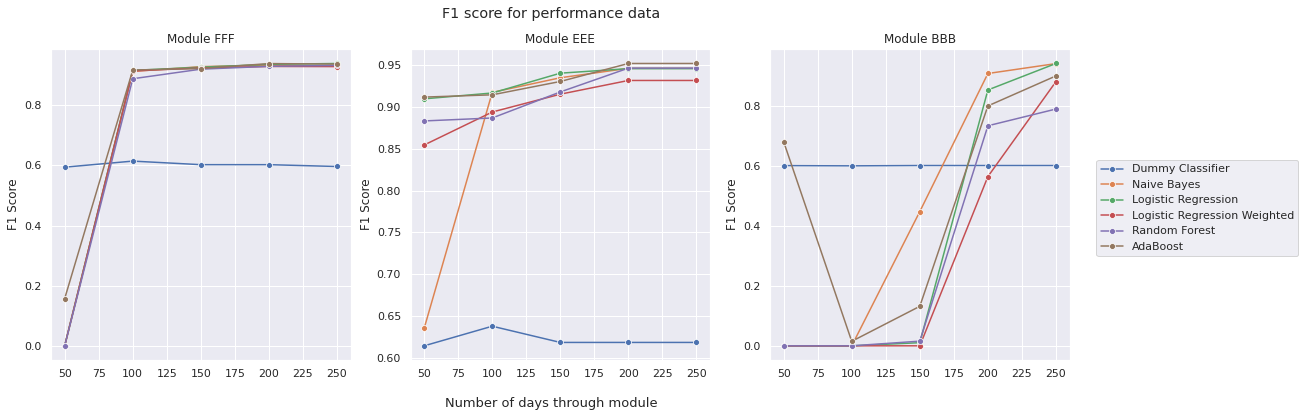

In [73]:
plot_days_compare(deadline_list[1:],performance_classifier_results,classifier_labels, "F1 score for performance data", module_titles, "performance_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


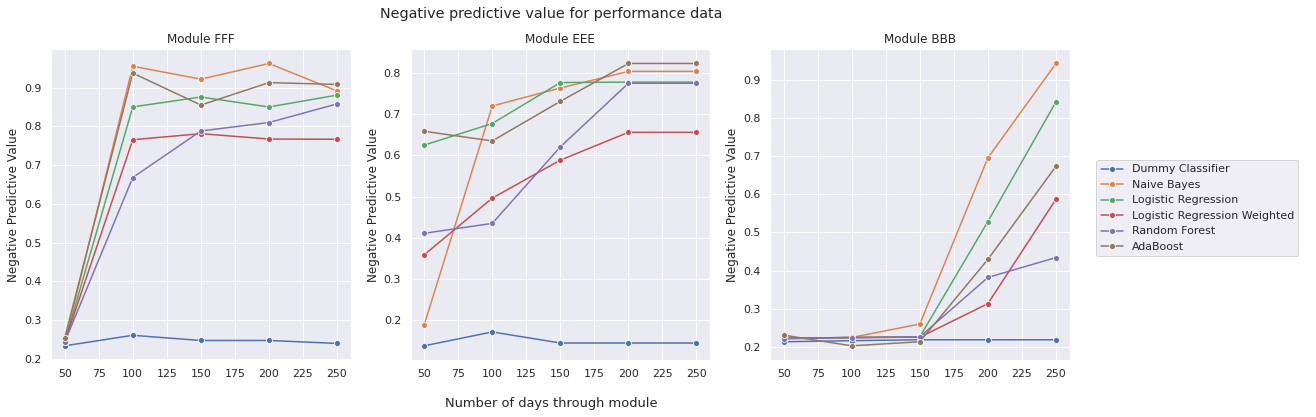

In [74]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,classifier_labels, "Negative predictive value for performance data", module_titles, "performance_npv.pdf")

#### All data (Demographic, Learning Behaviour, Performance)

##### Prepare data for prediction

In [75]:
all_df_FFF = {}
for i in df_FFF.keys():
  all_df_FFF[i] = split_dataframe_by_data_type(df_FFF[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

all_df_EEE = {}
for i in df_EEE.keys():
  all_df_EEE[i] = split_dataframe_by_data_type(df_EEE[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

all_df_BBB = {}
for i in df_BBB.keys():
  all_df_BBB[i] = split_dataframe_by_data_type(df_BBB[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [76]:
for i in list(df_FFF)[1:2]:
  all_df_FFF[i] = all_df_FFF[i].drop(columns=["score","weighted_score"])

for i in list(df_FFF)[2:]:
  all_df_FFF[i] = all_df_FFF[i].drop(columns=["score"])


for i in list(df_EEE)[1:1]:
  all_df_EEE[i] = all_df_EEE[i].drop(columns=["score","weighted_score"])

for i in list(df_EEE)[1:]:
  all_df_EEE[i] = all_df_EEE[i].drop(columns=["score"])


for i in list(df_BBB)[1:-2]:
  all_df_BBB[i] = all_df_BBB[i].drop(columns=["score","weighted_score"])

for i in list(df_BBB)[-2:]:
  all_df_BBB[i] = all_df_BBB[i].drop(columns=["score"])

###### Encode data

In [77]:
X_train_FFF, X_test_FFF, Y_train_FFF, Y_test_FFF = encode_data(all_df_FFF, ["2013J"], "2014J")

X_train_EEE, X_test_EEE, Y_train_EEE, Y_test_EEE = encode_data(all_df_EEE, ["2013J"], "2014J")

X_train_BBB, X_test_BBB, Y_train_BBB, Y_test_BBB = encode_data(all_df_BBB, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['mean_click', 'forumng', 'subpage', 'oucontent', 'glossary', 'ouwiki',
       'homepage', 'quiz', 'resource', 'url', 'oucollaborate', 'dualpane',
       'page', 'questionnaire'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['mean_click', 'forumng', 'subpage', 'oucontent', 'glossary', 'ouwiki',
       'homepage', 'quiz', 'resource', 'url', 'oucollaborate', 'dualpane',
       'page', 'questionnaire'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['mean_click', 'forumng', 'subpage', 'oucontent', 'glossary', 'ouwiki',
       'homepage', 'quiz', 'resource', 'url', 'oucollaborate', 'dualpane',
       'repeatactivity', 'page', 'questionnaire', 'weighted_score'],
      dtype='o

###### Reduce dimensions

In [78]:
for i in df_FFF.keys():
  pca = PCA(n_components='mle')

  X_train_FFF[i] = pca.fit_transform(X_train_FFF[i], Y_train_FFF[i])                             
  
  X_test_FFF[i] = pca.transform(X_test_FFF[i])


for i in df_EEE.keys():
  pca = PCA(n_components='mle')

  X_train_EEE[i] = pca.fit_transform(X_train_EEE[i], Y_train_EEE[i])                             
  
  X_test_EEE[i] = pca.transform(X_test_EEE[i])


for i in df_BBB.keys():
  pca = PCA(n_components='mle')

  X_train_BBB[i] = pca.fit_transform(X_train_BBB[i], Y_train_BBB[i])                             
  
  X_test_BBB[i] = pca.transform(X_test_BBB[i])

###### Feature selection

In [79]:
for i in df_FFF.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train_FFF[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_FFF[i], Y_train_FFF[i]))

  X_test_FFF[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_FFF[i]))

for i in df_EEE.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train_EEE[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_EEE[i], Y_train_EEE[i]))

  X_test_EEE[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_EEE[i]))


for i in df_BBB.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train_BBB[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train_BBB[i], Y_train_BBB[i]))

  X_test_BBB[i] = pd.DataFrame(feature_selection_transformer.transform(X_test_BBB[i]))

##### DummyClassifier

In [80]:
def all_du(df,X_train,Y_train,X_test,Y_test):
  all_results_du = []

  pipeline = Pipeline([
      ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_du.append([acc, f1, prec, recall, conf])
    print("\n")
  return all_results_du

In [81]:
all_results_du_FFF = all_du(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_du_EEE = all_du(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_du_BBB = all_du(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.485
Best parameters set:
Accuracy: 0.5060698027314112, F1 Score: 0.6052152819890844, Precision: 0.7595129375951294, Recall: 0.5030241935483871


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.4902102973168963, F1 Score: 0.5943450663589152, Precision: 0.7474600870827286, Recall: 0.4932950191570881


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best parameters set:
Accuracy: 0.5158959537572254, F1 Score: 0.6144994246260069, Precision: 0.7705627705627706, Recall: 0.5110047846889952


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.521
Best

##### NaiveBayes

In [82]:
def all_nb(df,X_train,Y_train,X_test,Y_test):
  all_results_nb = []

  pipeline = Pipeline([
      ('clf', GaussianNB()),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_nb.append([acc, f1, prec, recall, conf])
    print("\n")

  return all_results_nb

In [83]:
all_results_nb_FFF = all_nb(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_nb_EEE = all_nb(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_nb_BBB = all_nb(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.609
Best parameters set:
Accuracy: 0.6949924127465857, F1 Score: 0.7961460446247465, Precision: 0.8010204081632653, Recall: 0.7913306451612904


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.654
Best parameters set:
Accuracy: 0.728788977519942, F1 Score: 0.8172043010752689, Precision: 0.8343313373253493, Recall: 0.8007662835249042


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.712
Best parameters set:
Accuracy: 0.8208092485549133, F1 Score: 0.8918918918918918, Precision: 0.8190552441953562, Recall: 0.9789473684210527


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.701
Best 

##### LogisticRegression

In [84]:
def all_lr(df,X_train,Y_train,X_test,Y_test):
  all_results_lr = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(max_iter=1000)),
  ])

  params = {
    'clf__penalty': ['l2', 'none']
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_lr.append([acc, f1, prec, recall, conf])
    print("\n")

  return all_results_lr

In [85]:
all_results_lr_FFF = all_lr(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_lr_EEE = all_lr(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_lr_BBB = all_lr(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.595
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7314112291350531, F1 Score: 0.8301343570057581, Precision: 0.7921245421245421, Recall: 0.8719758064516129


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.657
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7556200145032632, F1 Score: 0.8430367955286446, Precision: 0.8204895738893926, Recall: 0.8668582375478927


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.840
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.865606936416185, F1 Score: 0.9148351648351649, Precision: 0.8770851624231782, Recall: 0.955980861244

##### WeightedLogisticRegression

In [86]:
def all_lrw(df,X_train,Y_train,X_test,Y_test):
  all_results_lrw = []

  pipeline = Pipeline([
      ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
  ])

  params = {
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_lrw.append([acc, f1, prec, recall, conf])
    print("\n")

  return all_results_lrw

In [87]:
all_results_lrw_FFF = all_lrw(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_lrw_EEE = all_lrw(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_lrw_BBB = all_lrw(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.623
Best parameters set:
Accuracy: 0.6145675265553869, F1 Score: 0.7018779342723005, Precision: 0.8398876404494382, Recall: 0.6028225806451613


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.673
Best parameters set:
Accuracy: 0.6439448875997099, F1 Score: 0.7279778393351801, Precision: 0.8633377135348226, Recall: 0.6293103448275862


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.819
Best parameters set:
Accuracy: 0.8497109826589595, F1 Score: 0.9, Precision: 0.9043478260869565, Recall: 0.8956937799043062


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.858
Best parameters set

##### RandomForest

In [88]:
def all_rf(df,X_train,Y_train,X_test,Y_test):

  all_results_rf = []
  all_features_rf = []

  pipeline = Pipeline([
      ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
  ])

  params = {
    'clf__n_estimators': [x for x in range(50,150,10)]
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_rf.append([acc, f1, prec, recall, conf])
    all_features_rf.append([tuned_model, X_test[i], Y_test[i]])

    print("\n")

  return all_results_rf, all_features_rf

In [89]:
all_results_rf_FFF,all_features_rf_FFF = all_rf(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_rf_EEE,all_features_rf_EEE = all_rf(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_rf_BBB,all_features_rf_BBB = all_rf(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.585
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.7344461305007587, F1 Score: 0.8362956033676333, Precision: 0.7801047120418848, Recall: 0.9012096774193549


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.598
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.73821609862219, F1 Score: 0.836281179138322, Precision: 0.7941429801894918, Recall: 0.8831417624521073


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.796
Best parameters set:
	clf__n_estimators: 1

##### AdaBoost

In [90]:
def all_ab(df,X_train,Y_train,X_test,Y_test):
  all_results_ab = []

  pipeline = Pipeline([
      ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
  ])

  params = {
    'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
  }

  for i in df.keys():
    print(f"Day {i}")
    grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(params)
    tuned_model = grid_search.fit(X_train[i], Y_train[i])

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

    predictions = tuned_model.predict(X_test[i])


    acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
    print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
    all_results_ab.append([acc, f1, prec, recall, conf])
    print("\n")
    
  return all_results_ab

In [91]:
all_results_ab_FFF = all_ab(df_FFF,X_train_FFF,Y_train_FFF,X_test_FFF,Y_test_FFF)

all_results_ab_EEE = all_ab(df_EEE,X_train_EEE,Y_train_EEE,X_test_EEE,Y_test_EEE)

all_results_ab_BBB = all_ab(df_BBB,X_train_BBB,Y_train_BBB,X_test_BBB,Y_test_BBB)

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.613
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7071320182094082, F1 Score: 0.8081510934393639, Precision: 0.7970588235294118, Recall: 0.8195564516129032


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.637
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.7440174039158811, F1 Score: 0.8371019843101062, Precision: 0.8076580587711487, Recall: 0.8687739463601533


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.827
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8641618497109826, F1 Sc

##### Plot results overview

In [92]:
all_classifier_results_FFF = [all_results_du_FFF, all_results_nb_FFF, all_results_lr_FFF, all_results_lrw_FFF, all_results_rf_FFF, all_results_ab_FFF]
all_classifier_results_EEE = [all_results_du_EEE, all_results_nb_EEE, all_results_lr_EEE, all_results_lrw_EEE, all_results_rf_EEE, all_results_ab_EEE]
all_classifier_results_BBB = [all_results_du_BBB, all_results_nb_BBB, all_results_lr_BBB, all_results_lrw_BBB, all_results_rf_BBB, all_results_ab_BBB]

all_classifier_results = [all_classifier_results_FFF,all_classifier_results_EEE,all_classifier_results_BBB]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


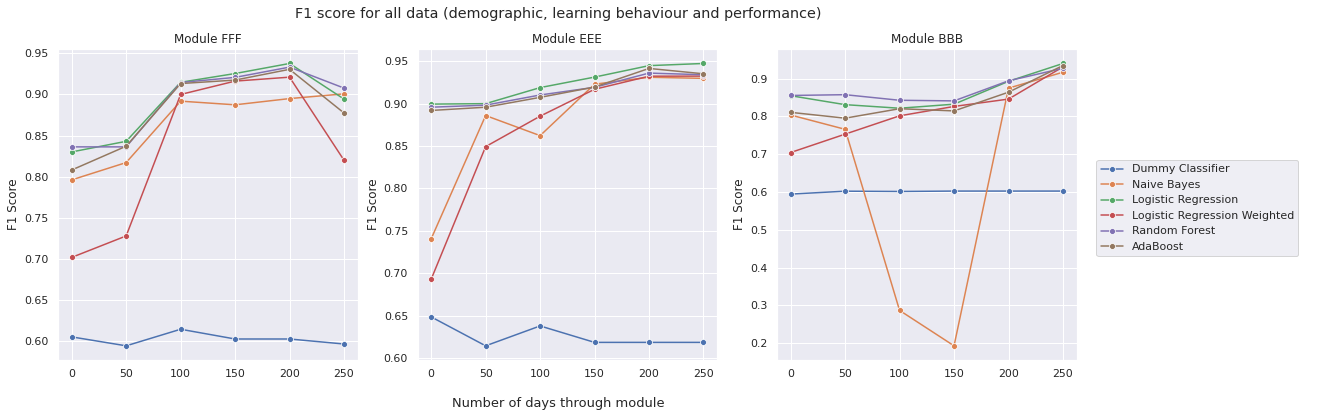

In [93]:
plot_days_compare(deadline_list,all_classifier_results,classifier_labels, "F1 score for all data (demographic, learning behaviour and performance)", module_titles, "all_f1.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


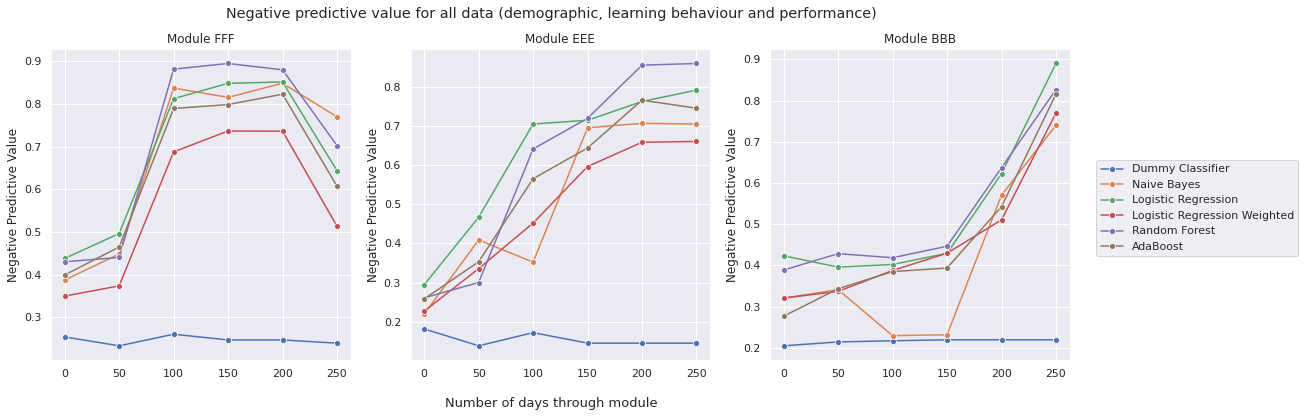

In [94]:
plot_days_compare_npv(deadline_list,all_classifier_results,classifier_labels, "Negative predictive value for all data (demographic, learning behaviour and performance)", module_titles, "all_npv.pdf")